In [102]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, basename
from uavsar_pytools.convert.tiff_conversion import read_annotation
from copy import deepcopy

In [2]:
desc = read_annotation('/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_grd/uticam_21003_21004_002_210120_L090_CX_01.ann')

In [101]:
nrows = desc['grd_pwr.set_rows']['value']
ncols = desc['grd_pwr.set_cols']['value']
fps = glob(join('/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_grd', '*.grd'))
pol = {}
for f in fps:
    name = basename(f).split('_')[-3][4:]
    if name == 'HVVV' or name == 'HHHV' or name == 'HHVV':
        arr = np.fromfile(f, dtype = np.complex64).reshape(nrows, ncols)
    else:
        arr = np.fromfile(f, dtype = np.float32).reshape(nrows, ncols)
    arr[arr == 0] = np.nan
    pol[name] = arr

In [4]:
C = np.array([[pol['HHHH'],np.sqrt(2)*pol['HHHV'],pol['HHVV']],
              [np.sqrt(2)*np.conjugate(pol['HHHV']),2*pol['HVHV'],np.sqrt(2)*pol['HVVV']],
              [np.conjugate(pol['HHVV']),np.sqrt(2)*np.conjugate(pol['HVVV']),pol['VVVV']]])

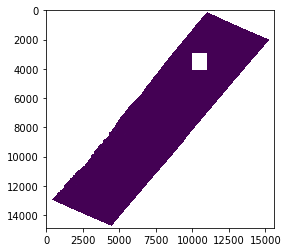

In [150]:
x_min, x_max = 3000,4000
y_min, y_max = 10000,11000
sub_VVVV = pol['VVVV'][x_min:x_max,y_min:y_max]
sub_HHHH = pol['HHHH'][x_min:x_max,y_min:y_max]
sub_HHVV = pol['HHVV'][x_min:x_max,y_min:y_max]
sub_HVHV = pol['HVHV'][x_min:x_max,y_min:y_max]
sub_HVVV = pol['HVVV'][x_min:x_max,y_min:y_max]
sub_HHHV = pol['HHHV'][x_min:x_max,y_min:y_max]
t = deepcopy(pol['VVVV'])
t[x_min:x_max,y_min:y_max] = np.nan
plt.imshow(t)

In [122]:
k = np.array([pol['HHHH'][x,y]+pol['VVVV'][x,y],pol['HHHH'][x,y]-pol['VVVV'][x,y],2*pol['HHVV'][x,y]])/np.sqrt(2)

In [123]:
T = np.matmul(k.reshape(3,1), np.conjugate(k).reshape(1,3))

In [124]:
values, vectors = np.linalg.eigh(T)

In [126]:
values

array([-3.71792433e-19,  2.10651591e-18,  3.80751054e-02])

In [137]:
np.rad2deg(np.arccos(vectors[0,2].real))

24.133746806766062

In [58]:
np.rad2deg(np.arccos(vectors[:, 2][0]).real)

24.133746806766062

In [ ]:
def calc_alpha_1(pHHHH, pVVVV, pHHVV):
    k = (np.array([pHHHH+pVVVV,pHHHH-pVVVV,2*pHHVV])/np.sqrt(2))
    T = np.matmul(k.reshape(3,1), np.conjugate(k).reshape(1,3))
    values, vectors = np.linalg.eigh(T)
    alpha_1 = np.rad2deg(np.arccos(vectors[0, 2]).real)
    return alpha_1

In [140]:
def calc_mean_alpha(pHHHH, pVVVV, pHHVV):
    k = (np.array([pHHHH+pVVVV,pHHHH-pVVVV,2*pHHVV])/np.sqrt(2))
    T = np.matmul(k.reshape(3,1), np.conjugate(k).reshape(1,3))
    values, vectors = np.linalg.eigh(T)
    alpha_1 = np.rad2deg(np.arccos(vectors[0, 2]).real)
    alpha_2 = np.rad2deg(np.arccos(vectors[1, 2]).real)
    alpha_3 = np.rad2deg(np.arccos(vectors[2, 2]).real)
    return np.mean([alpha_1,alpha_2, alpha_3])

In [163]:
def calc_c3(pHHHH, pHHHV, pHVHV, pHVVV, pHHVV, pVVVV):
    c11 = pHHHH
    c12 = np.sqrt(2)*pHHHV
    c13 = pHHVV
    c21 = np.sqrt(2)*np.conjugate(pHHHV)
    c22 = 2*pHVHV
    c23 = np.sqrt(2)*pHVVV
    c31 = np.conjugate(pHHVV)
    c32 = np.sqrt(2)*np.conjugate(pHVVV)
    c33 = pVVVV
    c3 = np.array([[c11,c12,c13],
    [c21,c22,c23],
    [c31,c32,c33]])
    return c3

In [159]:
def C3_to_T3(c):
    t11 = 0.5*(c[0,0]+2*c[0,2].real + c[2,2])
    t21 = 0.5*(c[0,0]-c[2,2]) + (-c[0,2].imag)*1j
    t31 = (c[0,1].real + c[1,2].real)/np.sqrt(2) + (c[0,1].imag - c[1,2].imag)/np.sqrt(2)*1j
    t22 = 0.5*c[0,0] - 2 * c[0,2].real + c[2,2]
    t32 = (c[0,1].real - c[1,2].real)/np.sqrt(2) + (c[0,1].imag + c[1,2].imag)/np.sqrt(2)*1j
    t33 = c[1,1]
    t12 = np.conjugate(t21)
    t13 = np.conjugate(t31)
    t23 = np.conjugate(t32)
    T3 = np.array([[t11,t12,t13],
                    [t21,t22,t23],
                    [t31,t32,t33]])
    return T3

In [160]:
def T3_to_alpha1(T3):
    values, vectors = np.linalg.eigh(T3)
    alpha_1 = np.rad2deg(np.arccos(vectors[0, 2]).real)
    return alpha_1

In [164]:
res = np.empty_like(sub_HHHH)*np.nan
for row in range(sub_HHHH.shape[0]):
    for col in range(sub_HHHH.shape[1]):
        if not np.isnan(sub_HHHH[row,col]):
            c3 = calc_c(sub_HHHH[row,col], sub_HHHV[row,col], sub_HVHV[row,col],sub_HVVV[row,col], sub_HHVV[row,col], sub_VVVV[row,col])
            t3 = C3_to_T3(c3)
            alpha_1 = T3_to_alpha1(t3)
            res[row, col] = alpha_1

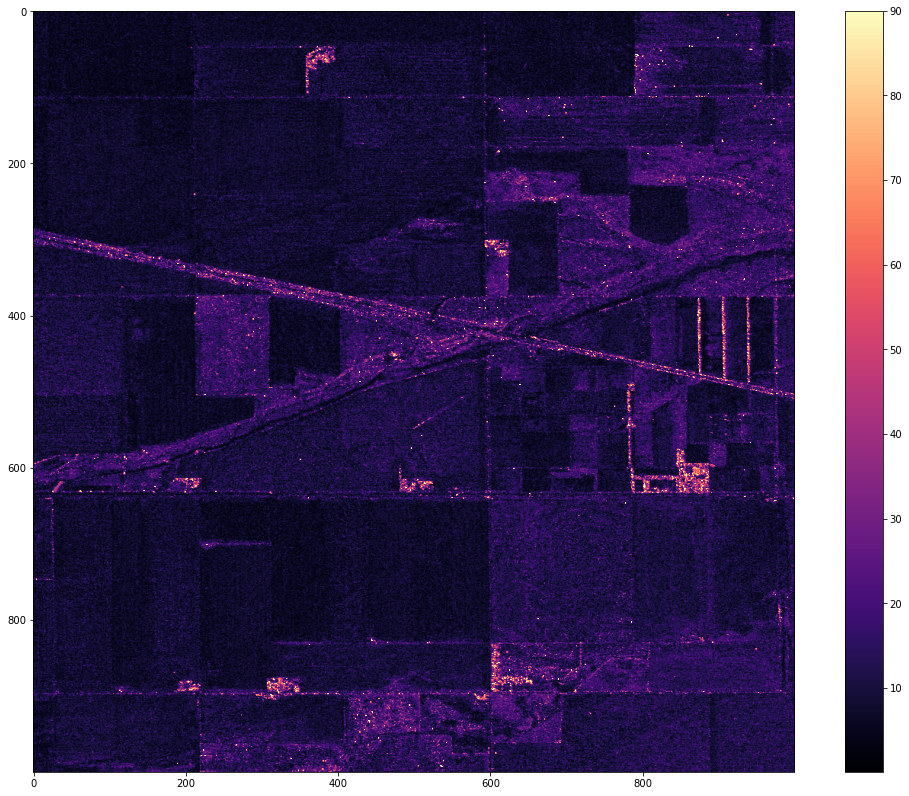

In [168]:
plt.subplots(figsize = (18,14))
plt.imshow(180 - res, vmin = 0.08, vmax = 90, cmap = 'magma')
plt.colorbar()

In [167]:
180 - res

array([[ 5.844681 ,  5.844681 ,  1.8195038, ..., 12.9592285, 12.9592285,
         8.572388 ],
       [ 8.845139 ,  3.018341 ,  3.018341 , ..., 10.713104 , 30.09401  ,
         8.572388 ],
       [ 8.260239 ,  8.260239 ,  7.4609375, ..., 10.622299 , 30.09401  ,
        21.179504 ],
       ...,
       [ 6.741974 ,  6.3618164,  6.3618164, ...,  6.1794586,  9.155899 ,
         9.155899 ],
       [ 6.279114 ,  6.279114 ,  6.760269 , ..., 13.885529 ,  9.2191925,
        15.526978 ],
       [ 9.531799 ,  3.1660461,  3.1660461, ..., 16.268875 ,  3.9757233,
         3.9757233]], dtype=float32)